In [68]:
import pandas as pd 
import numpy as np
import seaborn as sns
from numpy import linalg as la
from tabulate import tabulate
import linearpaneldata as lpd   # simple routines to do linear FE and Pooled OLS regressions
import indexmodels  
import logit
import indexmodels2021            # objective functions etc. for estimation of panel data binary response models
import mestim as M              # routines for M-estimation given general sample objective functions


> ### Opstilling af Nulhypotese og Alternativ Hypotese 
> Hypotesetesten sigter mod at undersøge, om der er state dependence, dvs. om tidligere fagforeningsmedlemskab påvirker nuværende medlemskab.
> **Nulhypotese ($H_0$): Ingen state dependence**
> $$H_0 : \rho = 0$$
> Tidligere medlemskab har ingen effekt på sandsynligheden for at være medlem i nuværende periode.
> Fagforeningsmedlemskab i t bestemmes udelukkende af kontrolvariablerne $z_{it}$ og den individuelle effekt $c_i$
> **Alternativ Hypotese ($H_A$): State dependence eksisterer**
> $$H_A : \rho \neq 0$$
> * Tidligere medlemskab har en signifikant effekt på sandsynligheden for at være medlem i dag.
> * Hvis $\rho > 0$, betyder det, at tidligere medlemskab øger sandsynligheden for fremtidigt medlemskab (positiv afhængighed).
> * Hvis $\rho < 0$, betyder det, at tidligere medlemskab reducerer sandsynligheden for fremtidigt medlemskab (negativ afhængighed).


In [69]:
# indlæs data
dat = pd.read_csv('union.csv')

In [70]:
dat.sample(5)

,nr,year,union,married,educ
600,1190,1980,0,0,12
883,1961,1983,0,1,12
3347,8581,1983,0,0,12
260,684,1984,0,1,12
1359,2980,1987,0,1,15


In [71]:
dat.year.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987])

In [72]:
df = dat[dat["year"] <= dat["year"].min() + 4].copy()


# Descriptives

In [73]:
df.describe()

,nr,year,union,married,educ
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,5262.058716,1982.000000,0.251009,0.355963,11.766972
std,3496.390456,1.414473,0.433673,0.478892,1.746302
min,13.000000,1980.000000,0.000000,0.000000,3.000000
25%,2329.000000,1981.000000,0.000000,0.000000,11.000000
50%,4569.000000,1982.000000,0.000000,0.000000,12.000000
75%,8406.000000,1983.000000,1.000000,1.000000,12.000000
max,12548.000000,1984.000000,1.000000,1.000000,16.000000


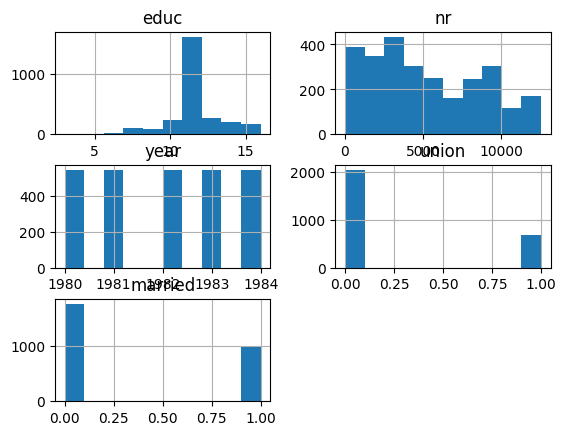

In [74]:
df[['educ','nr','year','union','married']].hist();

# Converting data to numpy format 

> ### Forstå modellen 
> 
> Vi har en dynamisk paneldata-model, hvor afhængige variabel $Union_{it}$ er binær (0 eller 1) 
> 
> * $G(*)$ er en link-funktion 
> * $\rho \cdot union_{it-1}$ betyder, at modellen er dynamisk (tidligere fagforeningsmedlemskab påvirker nutidigt medlemskab)
> * $c_i$ er en individuel effekt, der kan være FE eller RE
> * $z_{it}$ er forklarende variabler (f.eks. $educ_{it}$ og $married_{it}$)
>
>### Hvordan relaterer det sig til en generel GLM (Generel Lineær Model)?
>En GLM er en generalisering af den klassiske lineære regression. Den bruges, når den afhængige variabel ikke nødvendigvis er kontinuert og normalfordelt, men i stedet kan være binær, tælledata, eller en anden type data.
>
> I GLM-modellen har vi tre vigtige elementer:
> * Stokastisk komponent: Beskriver fordelingen af den afhængige variabel Y
> * Systematisk komponent: En lineær kombination af forklarende variabler X
> * Link-funktion: Forbinder den systematiske komponent med den stokastiske komponent.
>
> Den generelle form for en GLM er: $$ g(E[Y_i|X_i]) = X_i\beta $$
> ## Hvordan passer din model ind i GLM?
>
>Din model estimerer sandsynligheden for, at en person er medlem af en fagforening (\(\text{union}_{it}\)), givet tidligere medlemskab og andre >forklarende variabler.  
>Den generelle form for din model er:
>
>$$
P(\text{union}_{it} = 1 | \text{union}_{i,t-1}, ..., \text{union}_{i0}, z_{it}, c_i) = G(z_{it} \gamma + \rho \cdot \text{union}_{i,t-1} + c_i)
>$$
>
>### Hvis vi sammenligner med en GLM:
> - Stokastisk komponent: $Y_{it} \sim \text{Bernoulli}(p_{it})$ fordi $ Y_{it} $ er binær.
>
>- Systematisk komponent: $\eta_{it} = z_{it} \gamma + \rho \cdot \text{union}_{i,t-1} + c_i$
>
> - Link-funktion:  
>  - Hvis \( G(x) \) er en logit-funktion:  
>    $$
    \log \left( \frac{P(Y=1)}{P(Y=0)} \right) = z_{it} \gamma + \rho \cdot \text{union}_{it-1} + c_i
>   $$
> 
>   hvilket viser, at den inverse logit-funktion bruges til at beregne sandsynligheder.
> * fordel: Gar en pæn odds-fortolkning og hurtigere beregninger
> * ulempe Mindre præcis i halerne af fordelingen  
>
>  * Hvis $G(x)$ er en normalfordelingsfunktion (probit):  
>    $$
    \Phi^{-1} (P(Y=1)) = z_{it} \gamma + \rho \cdot \text{union}_{it-1} + c_i
>    $$
>    Dette er en probit-GLM.
> * Fordel: Passer bedre til data, der følger en normalfordeling
> * Beregningsmæssigt tungere
>
> ### Hvordan passer FE og RE i GLM? 
> Fixed Effects (FE) Logit: Estimeres med betinget likelihood, hvor vi fjerner $c_i$ ved at betinget på summen af $Y_{it}$
>
> Random Effects (RE) Logit: Modellerer $c_i$ som en normalfordelt latent effekt, hvilket passer til GLM med hierarkisk struktur.
>
>
>
> ### Ud fra GLM kan vi direkte se, at vi skal bruge en logit-model:
>
>Vores afhængige variabel er binær → GLM kræver en link-funktion.
> Logit-link sikrer, at sandsynligheder forbliver mellem 0 og 1 
> Logistisk fordeling passer ofte bedre end normalfordeling.
> Teoretiske argumenter for logit over probit:
>
> Logit har en naturlig fortolkning i form af odds-ratioer.
> Logit er numerisk mere stabil og hurtigere end probit.
> Logistisk fordeling håndterer ekstreme værdier bedre end normalfordelingen.
> Valget mellem FE og RE:
>
> FE logit bruges, hvis vi tror, at $c_i$ er korreleret med $X_{it}$
> 
> RE logit bruges, hvis $c_i$ ikke er korreleret med $X_{it}$
> 



In [75]:
df.union.values.shape

(2725,)

> ## Opstil varaiblerne ud fra modellen


In [76]:
# Opret lagged værdi af 'union' for hver individ
df['union_lag'] = df.groupby('nr')['union'].shift(1)

# Fjern første års observationer (som har NaN i `union_lag`)
df = df.dropna(subset=['union_lag']).copy()

# Tilføj en konstant 1-variabel (hvis nødvendigt)
df.loc[:, 'c_i'] = 1  

# Tjek om problemet er løst
print(df)

         nr  year  union  married  educ  union_lag  c_i
1        13  1981      1        0    14        0.0    1
2        13  1982      0        0    14        1.0    1
3        13  1983      0        0    14        0.0    1
4        13  1984      0        0    14        0.0    1
9        17  1981      0        0    13        0.0    1
...     ...   ...    ...      ...   ...        ...  ...
4348  12534  1984      0        1    11        0.0    1
4353  12548  1981      0        0     9        0.0    1
4354  12548  1982      0        0     9        0.0    1
4355  12548  1983      0        1     9        0.0    1
4356  12548  1984      1        1     9        0.0    1

[2180 rows x 7 columns]


In [77]:
Nobs, k, n, T, y, x = indexmodels.panel_setup(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr')

Pooled Logit 

In [78]:
result_pooled = indexmodels.pooled(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='logit')

Pooled logit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag       3.11384     0.16199    19.22298    -0.00000     0.37261
married         0.08168     0.12747     0.64075     0.00001     0.00977
educ           -0.19003     0.00907   -20.96192     0.00003    -0.02274

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -859.6192116556285 

Iteration info: 6 iterations, 7 evaluations of objective, and 7 evaluations of gradients
Elapsed time: 0.0221 seconds



In [79]:
beta_init = result_pooled.theta_hat  # Ekstraherer de estimerede parametre

log_likelihood = indexmodels.Q_pooled(y, x, T, beta_init, model='logit', out='Q')
print("Negativ log-likelihood (Q_pooled):", log_likelihood)


Negativ log-likelihood (Q_pooled): 1.577282957166291


Random Effects Logit 

In [80]:
result_re = indexmodels.rand_effect(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='logit')


Random effects logit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag       2.56729     0.24672    10.40548     0.00000     0.27438
married         0.08156     0.17086     0.47736     0.00000     0.00872
educ           -0.20607     0.01212   -16.99811     0.00000    -0.02202
sigma_a         1.34293     0.27702     4.84772     0.00000     0.14352

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -852.021856227748 

Iteration info: 22 iterations, 25 evaluations of objective, and 25 evaluations of gradients
Elapsed time: 0.1311 seconds



In [81]:
beta_init1 = result_re.theta_hat  # Ekstraherer de estimerede parametre

log_likelihood = indexmodels.Q_RE(y, x, T, beta_init1, model='logit', out='Q')
print("Negativ log-likelihood (Q_pooled):", log_likelihood)


Negativ log-likelihood (Q_pooled): 1.5633428554637578


Fixed Effects logit

In [82]:
result_fe = indexmodels.fe_logit_likelihood(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='logit')

AttributeError: module 'indexmodels' has no attribute 'fe_logit_likelihood'

In [ ]:
print(dir(indexmodels))


['G', 'M', 'Q_RE', 'Q_pooled', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'addlag', 'g', 'la', 'minimize', 'norm', 'np', 'panel_setup', 'pd', 'plt', 'pooled', 'print_output', 'prodby', 'quad_xw', 'rand_effect', 'random', 'simulate', 'sumby', 'tabulate']


Test